In [55]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [15]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined_vgg16_imbalaned.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3450, 224, 224, 3)
y_train shape: (3450,)
X_valid shape: (864, 224, 224, 3)
y_valid shape: (864,)
X_test shape: (1080, 224, 224, 3)
y_test shape: (1080,)


In [16]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

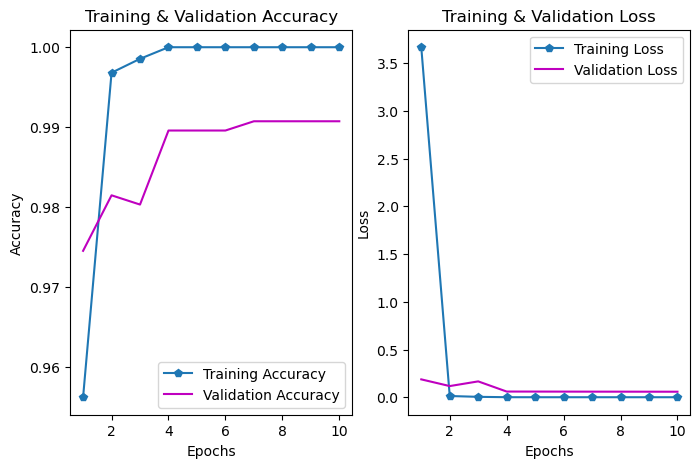

In [8]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


40/40 [==============================] - 285s 7s/step


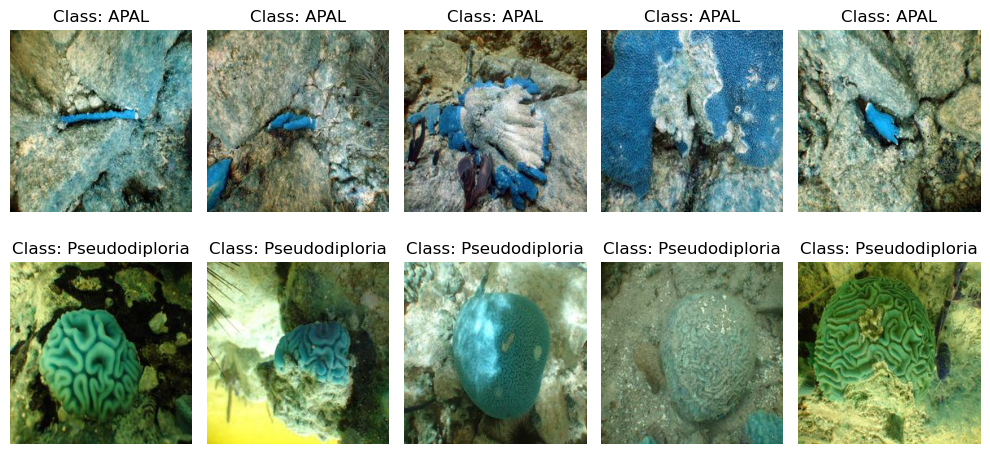

In [11]:
import matplotlib.pyplot as plt

# Assuming y_pred contains predicted class labels for X_test
y_pred = model.predict(X_test).argmax(axis=1)  # Convert to class labels

# Convert predictions to class names using the label_encoder
predicted_class_names = label_encoder.inverse_transform(y_pred)

# Define the number of images to display for each class
num_images_per_class = 5

# Get unique class labels from y_pred
unique_classes = np.unique(predicted_class_names)

# Initialize a variable to keep track of displayed images
images_displayed_per_class = {label: 0 for label in unique_classes}

# Create a figure to display the images
fig, axes = plt.subplots(len(unique_classes), num_images_per_class, figsize=(10, 5))

# Loop through the X_test and y_pred to display the images
for i in range(len(X_test)):
    label = predicted_class_names[i]
    if images_displayed_per_class[label] < num_images_per_class:
        ax = axes[np.where(unique_classes == label)[0][0], images_displayed_per_class[label]]
        # Normalize the image to the [0, 1] range
        normalized_image = X_test[i] / 255.0
        ax.imshow(normalized_image)
        ax.axis('off')
        ax.set_title(f"Class: {label}")
        images_displayed_per_class[label] += 1
    if all(value >= num_images_per_class for value in images_displayed_per_class.values()):
        break

# Display the plot
plt.tight_layout()
plt.show()


In [17]:
from keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # Reduced the number of neurons
output = Dense(num_classes, activation='softmax')(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a lower learning rate (to slow down convergence)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 570s 5s/step - loss: 0.5599 - accuracy: 0.9519 - val_loss: 0.1674 - val_accuracy: 0.9664
Epoch 2/10
108/108 [==============================] - 560s 5s/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.1653 - val_accuracy: 0.9734
Epoch 3/10
108/108 [==============================] - 559s 5s/step - loss: 1.1037e-04 - accuracy: 1.0000 - val_loss: 0.1476 - val_accuracy: 0.9780
Epoch 4/10
108/108 [==============================] - 559s 5s/step - loss: 2.4020e-05 - accuracy: 1.0000 - val_loss: 0.1461 - val_accuracy: 0.9780
Epoch 5/10
108/108 [==============================] - 559s 5s/step - loss: 1.9694e-05 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9780
Epoch 6/10
108/108 [==============================] - 558s 5s/step - loss: 1.6438e-05 - accuracy: 1.0000 - val_loss: 0.1440 - val_accuracy: 0.9780
Epoch 7/10
108/108 [==============================] - 569s 5s/step - loss: 1.3928e-05 - accuracy: 1.0000 - val_loss: 0.1432 - 

In [18]:
model.save('../models/coral_vgg16_layer02_im_(non-normalized).h5')

In [19]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 140s 4s/step - loss: 0.4430 - accuracy: 0.9676
Accuracy of the model(Two layers) is: 96.75925970077515 %
34/34 [==============================] - 139s 4s/step
Cohen's Kappa(Two layers): 0.7993119266055047
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.94      0.72      0.82       108
Pseudodiploria       0.97      0.99      0.98       972

      accuracy                           0.97      1080
     macro avg       0.95      0.86      0.90      1080
  weighted avg       0.97      0.97      0.97      1080



In [27]:
from keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # Reduced the number of neurons
output = Dense(num_classes, activation='softmax')(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Compile the model with a lower learning rate (to slow down convergence)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 556s 5s/step - loss: 0.8898 - accuracy: 0.9325 - val_loss: 0.1370 - val_accuracy: 0.9572
Epoch 2/10
108/108 [==============================] - 556s 5s/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.1609 - val_accuracy: 0.9595
Epoch 3/10
108/108 [==============================] - 556s 5s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.1296 - val_accuracy: 0.9606
Epoch 4/10
108/108 [==============================] - 555s 5s/step - loss: 3.3508e-04 - accuracy: 1.0000 - val_loss: 0.1332 - val_accuracy: 0.9606
Epoch 5/10
108/108 [==============================] - 556s 5s/step - loss: 2.2012e-04 - accuracy: 1.0000 - val_loss: 0.1344 - val_accuracy: 0.9618
Epoch 6/10
108/108 [==============================] - 555s 5s/step - loss: 1.6338e-04 - accuracy: 1.0000 - val_loss: 0.1348 - val_accuracy: 0.9630
Epoch 7/10
108/108 [==============================] - 555s 5s/step - loss: 1.2800e-04 - accuracy: 1.0000 - val_loss: 0.1358 - val_

In [28]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 139s 4s/step - loss: 0.2553 - accuracy: 0.9648
Accuracy of the model(Two layers) is: 96.4814841747284 %
34/34 [==============================] - 139s 4s/step
Cohen's Kappa(Two layers): 0.7907488986784141
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.88      0.75      0.81       108
Pseudodiploria       0.97      0.99      0.98       972

      accuracy                           0.96      1080
     macro avg       0.93      0.87      0.90      1080
  weighted avg       0.96      0.96      0.96      1080



In [36]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # Reduced the number of neurons
x = Dropout(0.5)(x)  # Increase dropout rate
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Define a function for the learning rate schedule
def lr_schedule(epoch):
    if epoch < 5:
        return 0.0001  # Keep the initial learning rate for the first 5 epochs
    else:
        return 0.00001  # Reduce the learning rate after 5 epochs

# Create a learning rate scheduler
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with the initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 562s 5s/step - loss: 0.7650 - accuracy: 0.9177 - val_loss: 0.1892 - val_accuracy: 0.9618
Epoch 2/10
108/108 [==============================] - 557s 5s/step - loss: 0.0847 - accuracy: 0.9852 - val_loss: 0.1351 - val_accuracy: 0.9722
Epoch 3/10
108/108 [==============================] - 555s 5s/step - loss: 0.0707 - accuracy: 0.9899 - val_loss: 0.1251 - val_accuracy: 0.9838
Epoch 4/10
108/108 [==============================] - 557s 5s/step - loss: 0.0538 - accuracy: 0.9942 - val_loss: 0.1091 - val_accuracy: 0.9803
Epoch 5/10
108/108 [==============================] - 558s 5s/step - loss: 0.0541 - accuracy: 0.9951 - val_loss: 0.1253 - val_accuracy: 0.9757
Epoch 6/10
108/108 [==============================] - 555s 5s/step - loss: 0.0458 - accuracy: 0.9974 - val_loss: 0.0906 - val_accuracy: 0.9850
Epoch 7/10
108/108 [==============================] - 555s 5s/step - loss: 0.0434 - accuracy: 0.9980 - val_loss: 0.0859 - val_accuracy: 0.9838

In [37]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 140s 4s/step - loss: 0.1670 - accuracy: 0.9796
Accuracy of the model(Two layers) is: 97.9629635810852 %
34/34 [==============================] - 140s 4s/step
Cohen's Kappa(Two layers): 0.8777777777777778
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.98      0.81      0.89       108
Pseudodiploria       0.98      1.00      0.99       972

      accuracy                           0.98      1080
     macro avg       0.98      0.91      0.94      1080
  weighted avg       0.98      0.98      0.98      1080



In [38]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(32, activation='relu')(x)  # Reduced the number of neurons
x = Dropout(0.5)(x)  # Increase dropout rate
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Define a function for the learning rate schedule
def lr_schedule(epoch):
    if epoch < 5:
        return 0.0001  # Keep the initial learning rate for the first 5 epochs
    else:
        return 0.00001  # Reduce the learning rate after 5 epochs

# Create a learning rate scheduler
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with the initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 595s 6s/step - loss: 0.8108 - accuracy: 0.8861 - val_loss: 0.1668 - val_accuracy: 0.9537
Epoch 2/10
108/108 [==============================] - 5398s 50s/step - loss: 0.1357 - accuracy: 0.9496 - val_loss: 0.1212 - val_accuracy: 0.9688
Epoch 3/10
108/108 [==============================] - 559s 5s/step - loss: 0.1084 - accuracy: 0.9722 - val_loss: 0.1055 - val_accuracy: 0.9815
Epoch 4/10
108/108 [==============================] - 559s 5s/step - loss: 0.0783 - accuracy: 0.9852 - val_loss: 0.0950 - val_accuracy: 0.9815
Epoch 5/10
108/108 [==============================] - 557s 5s/step - loss: 0.0783 - accuracy: 0.9867 - val_loss: 0.0747 - val_accuracy: 0.9919
Epoch 6/10
108/108 [==============================] - 557s 5s/step - loss: 0.0609 - accuracy: 0.9907 - val_loss: 0.0730 - val_accuracy: 0.9884
Epoch 7/10
108/108 [==============================] - 558s 5s/step - loss: 0.0587 - accuracy: 0.9930 - val_loss: 0.1038 - val_accuracy: 0.98

In [39]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 141s 4s/step - loss: 0.1081 - accuracy: 0.9843
Accuracy of the model(Two layers) is: 98.42592477798462 %
32/34 [===========================>..] - ETA: 8s 

KeyboardInterrupt: 

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(16, activation='relu')(x)  # Reduced the number of neurons
x = Dropout(0.5)(x)  # Increase dropout rate
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Define a function for the learning rate schedule
def lr_schedule(epoch):
    if epoch < 5:
        return 0.0001  # Keep the initial learning rate for the first 5 epochs
    else:
        return 0.00001  # Reduce the learning rate after 5 epochs

# Create a learning rate scheduler
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with the initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


In [ ]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


In [51]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined_vgg16_imbalaned_v2.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3450, 224, 224, 3)
y_train shape: (3450,)
X_valid shape: (864, 224, 224, 3)
y_valid shape: (864,)
X_test shape: (1080, 224, 224, 3)
y_test shape: (1080,)


In [52]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

In [44]:
from keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(32, activation='relu')(x)  # Reduced the number of neurons
output = Dense(num_classes, activation='softmax')(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Compile the model with a lower learning rate (to slow down convergence)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 561s 5s/step - loss: 0.9956 - accuracy: 0.8948 - val_loss: 0.1698 - val_accuracy: 0.9502
Epoch 2/10
108/108 [==============================] - 559s 5s/step - loss: 0.0410 - accuracy: 0.9870 - val_loss: 0.1399 - val_accuracy: 0.9630
Epoch 3/10
108/108 [==============================] - 559s 5s/step - loss: 0.0108 - accuracy: 0.9980 - val_loss: 0.1392 - val_accuracy: 0.9676
Epoch 4/10
108/108 [==============================] - 558s 5s/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 0.1437 - val_accuracy: 0.9699
Epoch 5/10
108/108 [==============================] - 558s 5s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1400 - val_accuracy: 0.9711
Epoch 6/10
108/108 [==============================] - 558s 5s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1516 - val_accuracy: 0.9711
Epoch 7/10
108/108 [==============================] - 558s 5s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1495 - val_accuracy: 0.9734

In [45]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 140s 4s/step - loss: 0.1723 - accuracy: 0.9667
Accuracy of the model(Two layers) is: 96.66666388511658 %
34/34 [==============================] - 140s 4s/step
Cohen's Kappa(Two layers): 0.7887323943661972
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.96      0.69      0.81       108
Pseudodiploria       0.97      1.00      0.98       972

      accuracy                           0.97      1080
     macro avg       0.96      0.85      0.89      1080
  weighted avg       0.97      0.97      0.96      1080



In [53]:
from keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(16, activation='relu')(x)  # Reduced the number of neurons
output = Dense(num_classes, activation='softmax')(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Compile the model with a lower learning rate (to slow down convergence)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 558s 5s/step - loss: 0.5979 - accuracy: 0.8852 - val_loss: 0.2090 - val_accuracy: 0.9468
Epoch 2/10
108/108 [==============================] - 556s 5s/step - loss: 0.0687 - accuracy: 0.9681 - val_loss: 0.1177 - val_accuracy: 0.9641
Epoch 3/10
108/108 [==============================] - 557s 5s/step - loss: 0.0234 - accuracy: 0.9922 - val_loss: 0.1009 - val_accuracy: 0.9699
Epoch 4/10
108/108 [==============================] - 557s 5s/step - loss: 0.0078 - accuracy: 0.9971 - val_loss: 0.1107 - val_accuracy: 0.9722
Epoch 5/10
108/108 [==============================] - 558s 5s/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.1006 - val_accuracy: 0.9734
Epoch 6/10
108/108 [==============================] - 558s 5s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9757
Epoch 7/10
108/108 [==============================] - 558s 5s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 0.9780

In [54]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 140s 4s/step - loss: 0.1229 - accuracy: 0.9741
Accuracy of the model(Two layers) is: 97.40740656852722 %
34/34 [==============================] - 140s 4s/step
Cohen's Kappa(Two layers): 0.8401826484018264
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.98      0.76      0.85       108
Pseudodiploria       0.97      1.00      0.99       972

      accuracy                           0.97      1080
     macro avg       0.98      0.88      0.92      1080
  weighted avg       0.97      0.97      0.97      1080



## without xml file data

In [47]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined_vgg16_imbalaned_v3.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3450, 224, 224, 3)
y_train shape: (3450,)
X_valid shape: (864, 224, 224, 3)
y_valid shape: (864,)
X_test shape: (1080, 224, 224, 3)
y_test shape: (1080,)


In [48]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

In [49]:
from keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(16, activation='relu')(x)  # Reduced the number of neurons
output = Dense(num_classes, activation='softmax')(x)  

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-1:]:
    layer.trainable = True

# Compile the model with a lower learning rate (to slow down convergence)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Now, you can train your model using your augmented and normalized data with early stopping
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
108/108 [==============================] - 588s 5s/step - loss: 0.7362 - accuracy: 0.8504 - val_loss: 0.2213 - val_accuracy: 0.9155
Epoch 2/10
108/108 [==============================] - 857s 8s/step - loss: 0.0953 - accuracy: 0.9649 - val_loss: 0.1449 - val_accuracy: 0.9456
Epoch 3/10
108/108 [==============================] - 557s 5s/step - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.1192 - val_accuracy: 0.9491
Epoch 4/10
108/108 [==============================] - 553s 5s/step - loss: 0.0152 - accuracy: 0.9983 - val_loss: 0.1093 - val_accuracy: 0.9583
Epoch 5/10
108/108 [==============================] - 559s 5s/step - loss: 0.0094 - accuracy: 0.9997 - val_loss: 0.1029 - val_accuracy: 0.9595
Epoch 6/10
108/108 [==============================] - 551s 5s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0981 - val_accuracy: 0.9618
Epoch 7/10
108/108 [==============================] - 550s 5s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0969 - val_accuracy: 0.9688

In [50]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


34/34 [==============================] - 140s 4s/step - loss: 0.1122 - accuracy: 0.9667
Accuracy of the model(Two layers) is: 96.66666388511658 %
34/34 [==============================] - 140s 4s/step
Cohen's Kappa(Two layers): 0.8068669527896996
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.87      0.79      0.83       108
Pseudodiploria       0.98      0.99      0.98       972

      accuracy                           0.97      1080
     macro avg       0.92      0.89      0.90      1080
  weighted avg       0.97      0.97      0.97      1080



## Testing on test data

In [56]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_test.npz')

# Access the arrays from the loaded data
X_test = data['X_test']
y_test = data['y_test']

# Print the shapes to verify
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (306, 224, 224, 3)
y_test shape: (306,)


In [58]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on your training labels
label_encoder.fit(y_train)

# Transform the test labels
y_test_encoded = label_encoder.transform(y_test)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)


In [59]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


10/10 [==============================] - 40s 4s/step - loss: 1.3864 - accuracy: 0.7222
Accuracy of the model(Two layers) is: 72.22222089767456 %
10/10 [==============================] - 40s 4s/step
Cohen's Kappa(Two layers): 0.43898019930115173
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.92      0.47      0.63       150
Pseudodiploria       0.66      0.96      0.78       156

      accuracy                           0.72       306
     macro avg       0.79      0.72      0.70       306
  weighted avg       0.79      0.72      0.70       306

